In [1]:
using Combinatorics
function Z_polynomial(n::Int64)
    """Coefficients for Z_j^0, from low degree to high degree."""
    function summand(k)
        n = big(n)
        k = big(k)
        # The normalization in the front seems right, according to Wikipedia.
        (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int(n/2) - k)*factorial(Int((n)/2) - k))
    end
    res = []
    for i in Array(range(0, stop=Int(n/2), step=1))
        push!(res, summand(i))
    end
    reverse(res)
end
function gaussian_coefficients(n, σ)
    """Integral of a Gaussian against an nth order polynomial from 0 to 1, times 2pi. n must be odd."""
    total = BigFloat(0)
    n = big(n)
    total = 1/2 * σ^2 * doublefactorial(n - 1) * (σ^2/2)^((n-1)/2)
    for i in range(0, Int64((n-1)/2), step = 1)
        total += -1/2 * σ^2 * exp(-1/σ^2) * (σ^2/2)^(i) * doublefactorial(n-1)/doublefactorial(n - 1 - 2 * i)
    end
    2 * π * total
end
function zernike_gaussian_coefficients(σ, m)
    """Try to reconstruct a gaussian, using Zernike polynomials up to order m"""
    coeffs = []
    for n in collect(2 * range(0, m/2, step=1))
        coeff = 0
        for (i, coefficient) in enumerate(Z_polynomial(Int64(n)))
            scalar = (2 * n + 2)/π
#             if n == 0
#                 scalar /= (2)
#             end
            coeff += coefficient/2 * gaussian_coefficients(2 * i - 1, σ) * scalar
        end
        push!(coeffs, coeff)
    end
    coeffs
    #coeffs /= sum([coeff * (-1)^(n+1) for (n, coeff) in enumerate(coeffs)])
end
function reconstruct_gaussian(ρ, σ, m)
    """Try to reconstruct a gaussian, using Zernike polynomials up to order m"""
    total = BigFloat(0)
    coeffs = zernike_gaussian_coefficients(σ, m)
    for (i, coeff) in enumerate(coeffs)
        total += coeff * (R(Int64(2*i - 2), 0, ρ)) # THIS WAS THE PROBLEM. MAKE SURE YOU'RE DOING THE MATH RIGHT.
    end
    total
end

reconstruct_gaussian (generic function with 1 method)

In [2]:
reconstruct_gaussian(1., 10, 0)

LoadError: UndefVarError: R not defined

In [3]:
function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

R (generic function with 1 method)

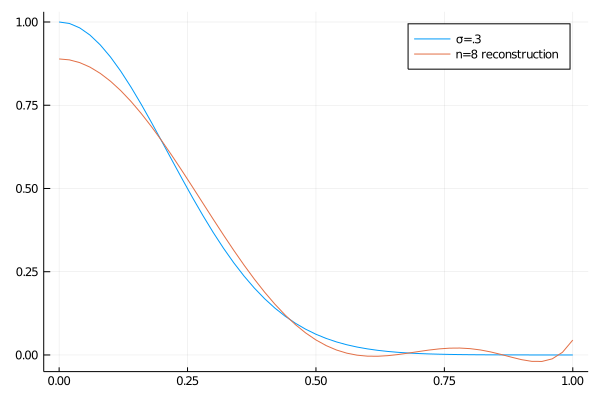

In [4]:
using Plots
# Including too many terms, esp. at high σ, breaks it.
for σ in [.3]
    max_ρ = 1
    min_ρ = 0
    num_samples = 50
    ρs = range(min_ρ, max_ρ, step=max_ρ/num_samples)
    max_n = 8
    ys = [reconstruct_gaussian(ρ, σ, max_n) for ρ in ρs];
    target = [exp(-ρ^2/σ^2) for ρ in ρs];
    display(plot(ρs, [target, ys], labels=["σ=.3" "n=8 reconstruction"]))
end

In [6]:
function gaussian(σ)
    function ret(ρ, ϕ)
        exp(-ρ^2/σ^2)
    end
    ret
end

gaussian (generic function with 1 method)

In [7]:
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

sample_across_unit_disk (generic function with 1 method)

In [8]:
function reconstruction(σ, max_n)
    function ret(ρ, ϕ)
        reconstruct_gaussian(ρ, σ, max_n)
    end
end

reconstruction (generic function with 1 method)

In [42]:
all_ns = []
all_rs = []
discretization = 50
tolerance = .01
σs = range(.1, 1, step=.1)
r2_vals = [1, .1, .01]
for r2_val in r2_vals
    r2s = []
    ns = []
    for σ in σs
        r2 = 1
        max_n = 1
        while r2 > r2_val
            count = 0
            zz = sample_across_unit_disk(gaussian(σ), discretization)[3]
            for el in zz
                if !isapprox(el, 0, atol=tolerance)
                    count += 1
                end
            end
            diff = sample_across_unit_disk(gaussian(σ), discretization)[3] - sample_across_unit_disk(reconstruction(σ, max_n), discretization)[3]
            diff = diff.*diff
            r2 = sum(diff)/count
            max_n += 1
        end
        push!(ns, max_n)
        push!(r2s, r2)
    end
    push!(all_ns, ns)
    push!(all_rs, r2s)
end

In [29]:
plot(heatmap(xx, yy, diff), aspectratio = true, xlabel="x", ylabel="y", title="Error in Reconstruction of a Gaussian using n <= 10")

LoadError: UndefVarError: xx not defined

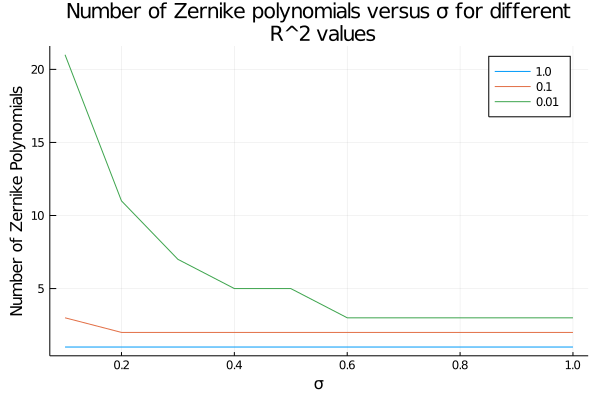

In [43]:
plot(σs, all_ns, label=transpose(hcat(r2_vals)), xlabel = "σ", ylabel="Number of Zernike Polynomials", title="Number of Zernike polynomials versus σ for different\n R^2 values")

# I need to figure out why I could get rid of the Neumann factor for the reconstruction...

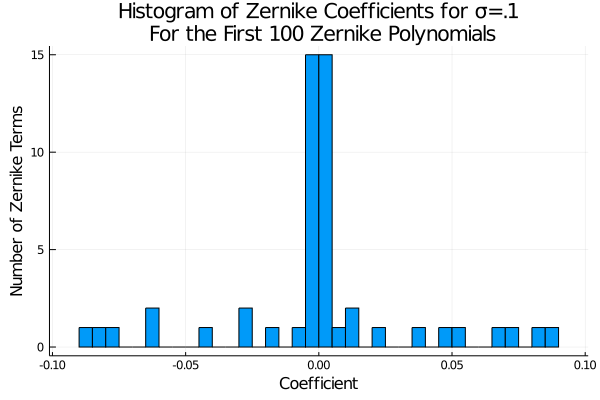

In [5]:
using Plots
histogram(zernike_gaussian_coefficients(.1, 100), bins=50, title="Histogram of Zernike Coefficients for σ=.1\n For the First 100 Zernike Polynomials", xlabel="Coefficient", ylabel="Number of Zernike Terms", legend=false)

In [17]:
plot(zernike_gaussian_coefficients(.1, 100).*zernike_gaussian_coefficients(.1, 500), title="Square of Coefficients for alpha_n^0, n even", xlabel="n", ylabel="|alpha_n^0|^2")

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 51 and 251")

In [16]:
zernike_gaussian_coefficients(.1, 100)

51-element Array{Any,1}:
  0.01000000000000000217129697059330761030232094306113697030259747418449073568451589
 -0.02940000000000000455798411193445302283568523805679591443379756631333057514533782
  0.04706000000000001129996205436388900577714958735743878519781568443097520114693174
 -0.06201160000000001662558819457054692262347962740247601115857145959244581142193177
  0.0735459120000000087830980010720590324758545849292222596297318122440240236663703
 -0.08126669936000001153788331710136186317719070447915576723527486610515717967237659
  0.08510364216640000343052395507912042656158028962210309424140751360717408561647793
 -0.08528713375008001207804269281134455093698594827835252138571511720667485434437425
  0.08229175274257280367499425989875829962957809278388164734805076467271619581479865
 -0.07675950337459033275553831712633711000746565842266119664836326064367248571599027
  0.06941552667643845956041773308498426848169295584320493864500389613805050283935678
 -0.0609882565507108160996692894547959491